In [ ]:
import os
import math
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import tqdm
import sklearn
import matplotlib

ox.settings.use_cache = True
ox.settings.log_console = True

# -----------------------
# USER PARAMETERS
# -----------------------

# must have columns: demand_id, lat, lon
#candidates_csv = "candidates.csv" # must have columns: candidate_id, lat, lon
od_out_csv = "od.csv"
network_mode = "drive"           # "drive","drive_service","walk","bike", etc.
crs = "epsg:4326"                # WGS84 coords in input files
default_speed_kph = 80.0         # fallback speed for edges missing maxspeed
use_osm_speeds = True            # use osmnx.add_edge_speeds if True
# -----------------------

# Load points
dem = pd.read_excel("Optimization Data.xlsx")
cand = pd.read_excel("Candidate Locations.xlsx", sheet_name="Candidate")
box = pd.read_excel("Candidate Locations.xlsx", sheet_name="Box")


# Basic checks
for df, name in [(dem, "demands"), (cand, "candidates")]:
    if not {"lat", "lon", df.columns[0]}.issubset(set(df.columns)):
        raise ValueError(f"{name}.csv must contain columns: id column, lat, lon. "
                         "Make sure the first column is the ID and named appropriately.")


Matplotlib is building the font cache; this may take a moment.


28.76963 28.079701 -97.325815 -98.13974


In [ ]:
print("Downloading/Loading OSM graph for Bee County, Texas, USA ...")
G = ox.graph.graph_from_place("Bee County, Texas, USA", network_type=network_mode)

# Preprocess edges: add speeds and travel time (meters, seconds, minutes)
if use_osm_speeds:
    # add_edge_speeds will attempt to parse maxspeed tags, otherwise fallback to default values per highway type
    try:
        G = ox.add_edge_speeds(G)  # kph stored in 'speed_kph' attribute
    except Exception as e:
        print("add_edge_speeds() failed, continuing with defaults. Error:", e)
        # continue; we'll set default speed below
# Ensure edge length exists (should)
G = ox.distance.add_edge_lengths(G)

# Add travel_time (seconds) attribute: if speed known use it, otherwise default
for u, v, k, data in G.edges(keys=True, data=True):
    length_m = data.get("length", None)  # meters
    if length_m is None:
        # safety fallback
        length_m = 0.0
    speed_kph = data.get("speed_kph", None)
    if speed_kph is None:
        # fallback heuristics: try to read 'maxspeed' or set default
        maxspeed = data.get("maxspeed", None)
        if isinstance(maxspeed, list):
            maxspeed = maxspeed[0] if maxspeed else None
        if maxspeed is not None:
            try:
                # maxspeed could be "30 mph" or "50"
                if isinstance(maxspeed, str) and "mph" in maxspeed.lower():
                    # parse mph
                    val = float(maxspeed.lower().replace("mph","").strip())
                    speed_kph = val * 1.60934
                else:
                    speed_kph = float(maxspeed)
            except Exception:
                speed_kph = default_speed_kph
        else:
            speed_kph = default_speed_kph
    # compute travel time seconds; length_m / (speed_m_per_s)
    speed_m_per_s = speed_kph * 1000.0 / 3600.0
    if speed_m_per_s <= 0:
        travel_time_s = math.inf
    else:
        travel_time_s = length_m / speed_m_per_s
    data["travel_time"] = travel_time_s
    data["travel_time_min"] = travel_time_s / 60.0

# Map points to nearest graph nodes
print("Mapping demand and candidate points to nearest graph nodes...")
# convert to lists of tuples (lon, lat) for osmnx nearest_nodes
dem_nodes = ox.nearest_nodes(G, dem["lon"].tolist(), dem["lat"].tolist())
cand_nodes = ox.nearest_nodes(G, cand["lon"].tolist(), cand["lat"].tolist())

dem["nearest_node"] = dem_nodes
cand["nearest_node"] = cand_nodes

# Some candidate nodes may be duplicates; we only need unique candidate nodes for multi-source lookups
unique_cand_nodes = np.unique(cand_nodes)
# Build mapping candidate_node -> list of candidate_ids (since multiple candidates could map to same node)
cand_node_to_ids = {}
for idx, row in cand.iterrows():
    node = row["nearest_node"]
    cand_node_to_ids.setdefault(node, []).append(row["candidate_id"])

# Prepare for shortest-path computations:
# We'll compute single-source shortest path lengths (by travel_time) from each demand node to all nodes,
# then extract travel_time to candidate nodes.
print("Computing shortest-path travel times from each unique demand node to candidate nodes...")

# For performance: if many demands share same nearest_node, compute unique demand nodes only once
unique_dem_nodes, inverse_idxs = np.unique(dem_nodes, return_inverse=True)
# Map node -> list of demand ids that map to it
dem_node_to_ids = {}
for i, row in dem.iterrows():
    node = row["nearest_node"]
    dem_node_to_ids.setdefault(node, []).append(row["demand_id"])

# We'll iterate unique_dem_nodes and compute single-source Dijkstra (weight='travel_time')
rows = []
pbar = tqdm.tqdm(unique_dem_nodes, desc="dem_nodes")
for source_node in pbar:
    # compute travel time (seconds) to all graph nodes using Dijkstra
    # note: networkx uses edge weights defined in data; use weight='travel_time'
    # use nx.single_source_dijkstra_path_length which returns length in same units as weight (seconds)
    lengths = nx.single_source_dijkstra_path_length(G, source_node, weight="travel_time")
    # For each candidate node, extract length (seconds). If no path, treat as inf
    for cand_node in unique_cand_nodes:
        t_s = lengths.get(cand_node, math.inf)
        # For each candidate_id mapped to cand_node, emit a row
        for candidate_id in cand_node_to_ids[cand_node]:
            # For each demand id that maps to source_node, emit a row
            for demand_id in dem_node_to_ids[source_node]:
                # convert seconds -> minutes; if inf, set to large number (or np.nan)
                if math.isinf(t_s):
                    t_min = np.nan
                else:
                    t_min = t_s / 60.0
                rows.append((demand_id, candidate_id, t_min))

# Build DataFrame and write CSV
od_df = pd.DataFrame(rows, columns=["demand_id", "candidate_id", "travel_time"])
print(f"Computed {len(od_df)} OD pairs. Saving to {od_out_csv} ...")
od_df.to_csv(od_out_csv, index=False)
print("Done.")

Downloading/Loading OSM graph for bbox: (np.float64(28.76963), np.float64(28.079701), np.float64(-97.325815), np.float64(-98.13974))
Mapping demand and candidate points to nearest graph nodes...
Computing shortest-path travel times from each unique demand node to candidate nodes...


dem_nodes: 100%|██████████| 9/9 [00:00<00:00, 182.90it/s]

Computed 126 OD pairs. Saving to od.csv ...
Done.


Zero-length edges: 22
Demands that map to the same node as a candidate: 0
7.177686834265561


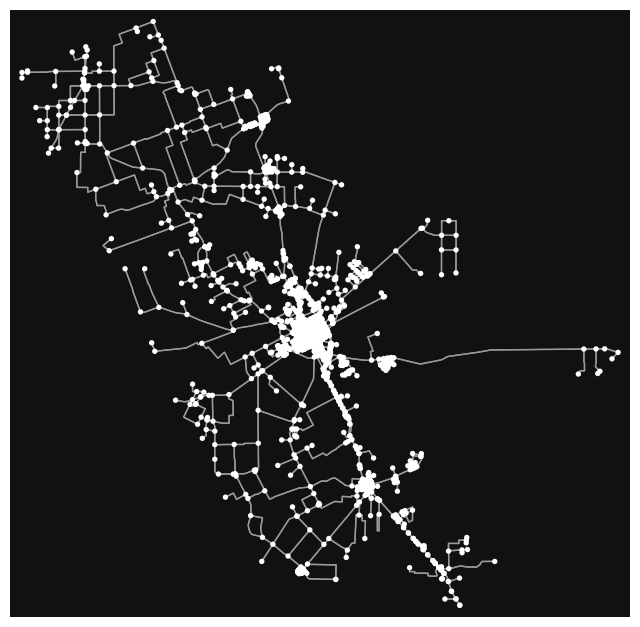

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [13]:
zero_length_edges = [(u, v, data) for u, v, data in G.edges(data=True) 
                     if data.get("length", 0) == 0]

print("Zero-length edges:", len(zero_length_edges))

same_node_pairs = np.sum(dem["nearest_node"].isin(cand["nearest_node"]))
print("Demands that map to the same node as a candidate:", same_node_pairs)

print(travel_time_s)
ox.plot_graph(G)

In [10]:
# vals = [d.get("travel_time", None) for _, _, d in G.edges(data=True)]
# print("Min travel time:", min(vals))
# print("Max travel time:", max(vals))
# print("Num zero travel times:", sum(v == 0 for v in vals if v is not None))

test_source = unique_dem_nodes[0]
lengths = nx.single_source_dijkstra_path_length(G, test_source, weight="travel_time")
print("Sample min travel time from source:", min(lengths.values()))
print("Sample max travel time from source:", max(lengths.values()))

Sample min travel time from source: 0
Sample max travel time from source: 0


In [ ]:
# --------------------------------------------------------
# Maximal Coverage Location Problem using GurobiPy
# Compatible with OSMnx-generated od.csv (travel_time in minutes)
# --------------------------------------------------------

import pandas as pd
from gurobipy import Model, GRB, quicksum

# --------------------------
# USER PARAMETERS
# --------------------------
demands_file = "demands.csv"        # columns: demand_id, pop, lat, lon
candidates_file = "candidates.csv"  # columns: candidate_id, lat, lon
od_file = "od.csv"                  # columns: demand_id, candidate_id, travel_time
T = 30                              # coverage threshold (minutes)
K = 2                               # max number of facilities to open
OUTPUT_SELECTED = "selected_sites.csv"
OUTPUT_COVERAGE = "demand_coverage.csv"
# --------------------------

# 1. Load data
dem = pd.read_csv(demands_file)
cand = pd.read_csv(candidates_file)
od = pd.read_csv(od_file)

# Basic checks
for col in ["demand_id", "pop"]:
    if col not in dem.columns:
        raise ValueError(f"demands.csv must contain column: {col}")
if "candidate_id" not in cand.columns:
    raise ValueError("candidates.csv must contain column: candidate_id")
if not all(c in od.columns for c in ["demand_id", "candidate_id", "travel_time"]):
    raise ValueError("od.csv must contain columns: demand_id, candidate_id, travel_time")

# 2. Sets and parameters
I = dem["demand_id"].unique().tolist()
J = cand["candidate_id"].unique().tolist()
pop = dem.set_index("demand_id")["pop"].to_dict()

# 3. Build coverage sets N_i (candidates that cover demand i)
print("Building coverage sets (within threshold)...")
N = {i: set(od.loc[(od["demand_id"] == i) & (od["travel_time"] <= T), "candidate_id"].unique()) for i in I}

# Warn if any demand is uncovered
uncovered = [i for i, candidates in N.items() if len(candidates) == 0]
if uncovered:
    print(f"⚠️ Warning: {len(uncovered)} demands have no candidate within {T} minutes.")

# 4. Build MILP
m = Model("MaxCoverage")
m.Params.OutputFlag = 1            # print solver log
m.Params.MIPGap = 1e-4             # relative optimality gap
m.Params.TimeLimit = 600           # seconds

# Decision variables
x = m.addVars(J, vtype=GRB.BINARY, name="x")  # 1 if facility j opened
z = m.addVars(I, vtype=GRB.BINARY, name="z")  # 1 if demand i covered

# Coverage constraints
for i in I:
    if len(N[i]) == 0:
        m.addConstr(z[i] == 0, name=f"cover_{i}_none")
    else:
        m.addConstr(z[i] <= quicksum(x[j] for j in N[i]), name=f"cover_{i}")

# Facility budget constraint
m.addConstr(quicksum(x[j] for j in J) <= K, name="facility_budget")

# Objective: maximize total population covered
m.setObjective(quicksum(pop[i] * z[i] for i in I), GRB.MAXIMIZE)

# 5. Solve model
m.optimize()

# 6. Extract and print results
if m.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
    selected = [j for j in J if x[j].X >= 0.5]
    print(f"\nSelected facilities ({len(selected)}): {selected}")

    z_opt = {i: int(round(z[i].X)) for i in I}
    covered_df = pd.DataFrame({
        "demand_id": list(z_opt.keys()),
        "covered": list(z_opt.values()),
        "pop": [pop[i] for i in I]
    })
    total_pop = sum(covered_df["pop"])
    covered_pop = (covered_df["pop"] * covered_df["covered"]).sum()
    coverage_pct = 100 * covered_pop / total_pop
    print(f"\nTotal population: {total_pop:,.0f}")
    print(f"Covered population: {covered_pop:,.0f} ({coverage_pct:.2f}% coverage)")

    # 7. Save outputs
    pd.DataFrame({"candidate_id": selected}).to_csv(OUTPUT_SELECTED, index=False)
    covered_df.to_csv(OUTPUT_COVERAGE, index=False)
    print(f"\nResults written to {OUTPUT_SELECTED} and {OUTPUT_COVERAGE}")
else:
    print("❌ Optimization did not converge properly. Status:", m.status)
